 # Modeling of a magnetic sphere

We start by importing the necessary packages:

In [1]:
# %matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

The anomaly of the total magnetic field for a sphere is given by:

$$
\delta \boldsymbol{B}(x)=\underbrace{\left\{\frac{\frac{4}{3} \pi R^{3} \kappa \boldsymbol{B
}_{0}}{4 \pi}\right\}}_{\text {factor }} \frac{3 d^{2} \sin ^{2} I+3 x^{2} \cos ^{2} I \cos ^{2} \alpha-3 x d \sin ^{2} I \cos \alpha-x^{2}-d^{2}}{\left(x^{2}+d^{2}\right)^{5 / 2}}
$$

where $R$ is the radius of the sphere, $\kappa$ the contrast in magnetic suscpetibility, $B_0$ is the background field, $I$ is the inclination, $d$ is the depth, $x$ are the measurement positions along the surface (zero centered again). An important factor is $\alpha$. It is the angle between your profile and the magnetic north.

In [2]:
def mag_sphere(r, k, B0, d, I, x, alpha):
    factor = (4/3 * np.pi * r**3 * k * B0*1e-9)/(4 * np.pi) 
    rest = (3 * d**2 * np.sin(I)**2 + 3*x**2 * np.cos(I)**2 * np.cos(alpha)**2 - 3*x*d*np.sin(I)**2 * np.cos(alpha) - x**2 - d**2)/(x**2 + d**2)**(5/2)
    return factor * rest * 1e9

In [3]:
x = np.linspace(-50, 50)
d = 10
k = 0.01
r = 5
alpha = np.deg2rad(0)
I = np.deg2rad(60)
B0 = 49000

## Visualization

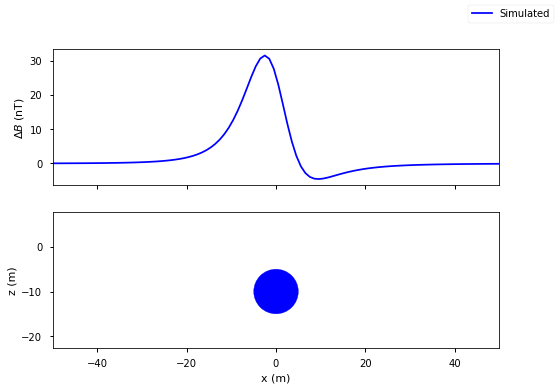

In [4]:
def plot_model(x, xpos, radius, depth, k, B0, I, alpha, B_mes=None):
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    xnum = np.linspace(x.min(), x.max(), 100) - xpos
    B_ana = mag_sphere(radius, k, B0, depth, I, xnum, alpha)
    if B_mes is not None:
        ax1.plot(x, B_mes, 'ro', label="Measured")
    line, = ax1.plot(xnum + xpos, B_ana, 'b-', label="Simulated")
    circle = plt.Circle((xpos, -depth), radius, color=line.get_color())
    ax1.set_ylabel(r"$\Delta B$ (nT)")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("z (m)")
    ax2.add_artist(circle)
    ax2.set_xlim(x.min(), x.max())
    ax2.set_ylim(-depth - 5, 0)
    ax2.set_aspect("equal")
    for ax in ax1, ax2:
        ax.set(adjustable='datalim')
    fig.legend()
    
plot_model(x, 0, r, d, k, B0, I, alpha)

# The effect of the inclination

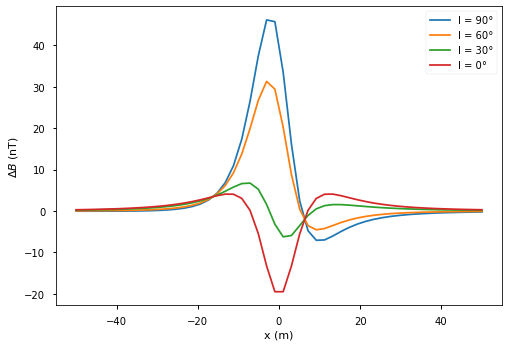

In [5]:
plt.figure()
for I in 90, 60, 30, 0:
    I_rad = np.deg2rad(I)
    B = mag_sphere(r, k, B0, d, I_rad, x, alpha)
    plt.plot(x, B, label="I = %d°" % I)
    
plt.legend()
plt.xlabel("x (m)")
plt.ylabel(r"$\Delta B$ (nT)");

# The effect of the profile orientation

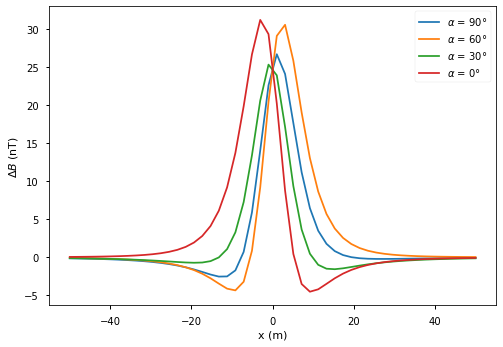

In [6]:
plt.figure()
for alpha in 90, 60, 30, 0:
    alpha_rad = np.deg2rad(alpha)
    B = mag_sphere(r, k, B0, d, np.deg2rad(60), x, alpha)
    plt.plot(x, B, label=r"$\alpha$ = %d°" % alpha)
    
plt.legend()
plt.xlabel("x (m)")
plt.ylabel(r"$\Delta B$ (nT)");

---

# Inversion of field data

As seen above, the magnetic response can look very different depending on inclination and profile orientation for the exact same subsurface structure. So it is important to account for the magnetic background field at the site. We can loopup the background field for the given location (e.g., Düriwss 50.829528 °N and 6.243917 °E) using the World Magnetic Model (WMM) for example (https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml?#igrfwmm) to find that:

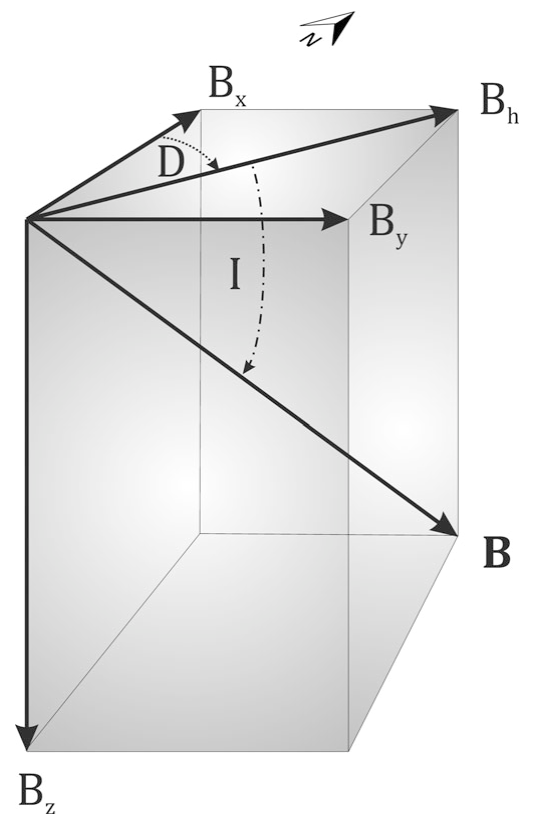

In [7]:
dec = 2.423120 # Declination in decimal degrees
inc = 66.26733 # Inclination in decimal degrees
Bh  = 19731.600 # Horizontal intensity (nT)
B0  = 49026.400 # Total intensity (nT)
Bx  = 19714.000 # X component (nT)
By  = 834.20000 # Y component (nT)
Bz  = 44880.400 # Z component (nT)

# The deviation of the profile from magnetic north is also important!

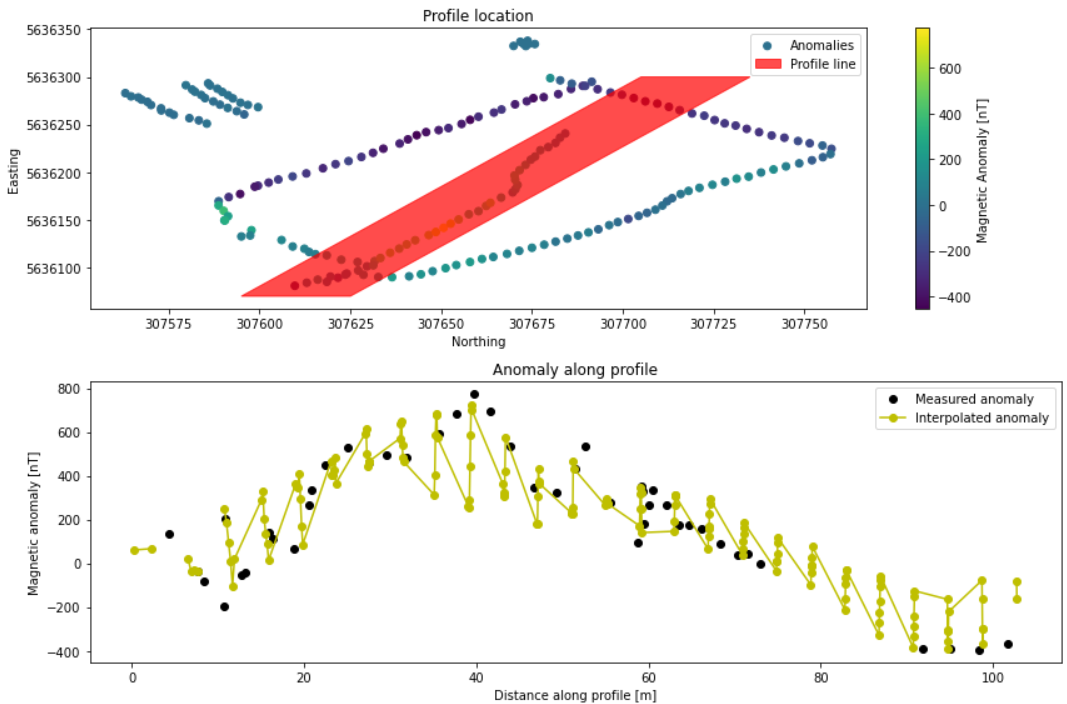

In [15]:
coords_x = [292228.19425724, 292262.16898583]
coords_y = [5630603.62526547,5630579.29902099]

diff_x = coords_x[1]-coords_x[0]
diff_y = coords_y[1]-coords_y[0]

length = np.sqrt(diff_x**2+diff_y**2)
alpha_mes = np.arctan(diff_x/diff_y)

print("Deviation from (magnetic) north = %.2f°" % np.rad2deg(alpha_mes))

Deviation from (magnetic) north = -54.40°


# Load actual measurement data

In [16]:
data = pd.read_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Student Data\Profiles\profile_interpolated.csv")
data.head()

,Unnamed: 0,Measured distance,Measured anomaly
0,0,0.250440,-178.615754
1,1,0.800754,-200.471813
2,2,1.075304,-176.325044
3,3,1.462425,-152.178276
4,4,1.648386,-174.034334


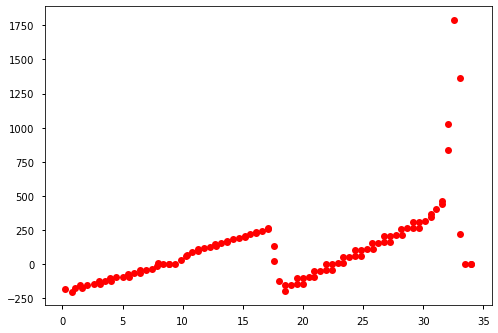

In [17]:
x_mes = data["Measured distance"]
B_mes = data["Measured anomaly"]

plt.figure()
plt.plot(x_mes, B_mes, "ro")

# Fit a sphere to the measured data

In [18]:
# starting values: x-postion, radius, depth (k remains fixed here for now)
p0 = 5, 2, 5

I_inv = np.deg2rad(inc)
k_inv = 0.1
alpha_inv = alpha_mes

def target(parameters):
    xpos, r, d = parameters
    simulated = mag_sphere(r, k_inv, B0, d, np.deg2rad(inc), x_mes - xpos, alpha_inv)
    return B_mes - simulated

from scipy.optimize import least_squares
result = least_squares(target, p0, bounds=([x_mes.min(), 1, 1], [x_mes.max(), 100, 50]))

In [19]:
x_opt, r_opt, d_opt = result.x
print(result.x)

[32.70526652  1.00711096  1.19944091]


In [20]:
xnum = np.linspace(x_mes.min(), x_mes.max(), 100) - x_opt
B_ana = mag_sphere(r_opt, k_inv, B0, d_opt, I_inv, xnum, alpha_inv)

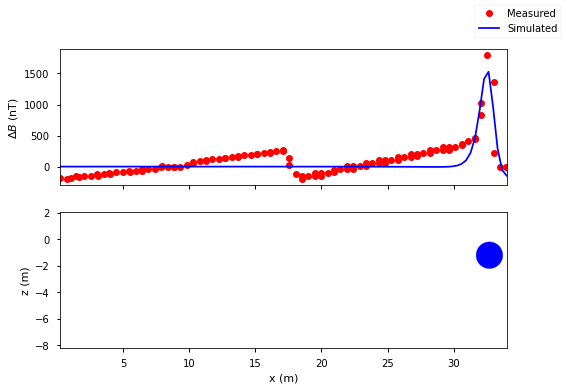

In [21]:
plot_model(x_mes, x_opt, r_opt, d_opt, k_inv, B0, I_inv, alpha_inv, B_mes=B_mes)